<a href="https://colab.research.google.com/github/ashwinvaswani/Generative-Modelling-of-Images-from-Speech/blob/master/src/keras/keras_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Dec 24 16:46:04 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# a = []
# while(True):
#   a.append('1')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import pickle
import numpy as np
import pandas as pd
import cv2

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D,AvgPool2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization,LeakyReLU,MaxPool2D,Conv1D
from keras.models import Sequential
from keras.layers import Conv2DTranspose,Reshape

In [0]:
PATH = './drive/My Drive/TIP/Dataset/'
PATH_TO_MAIN = './drive/My Drive/TIP/'
YT_LINK = 'www.youtube.com/watch?v='

In [0]:
with open(PATH_TO_MAIN + 'Pickles/y_pred_encoder_81.pkl','rb') as f:
    x_train_decoder= pickle.load(f)

In [9]:
filenames = []
for elem in os.listdir(PATH_TO_MAIN + './Face_Images'):
  filenames.append(elem)

decoder_train_df = pd.DataFrame(filenames,columns = ['filename'])
decoder_train_df.head()

,filename
0,AvWWVOgaMlk.png
1,Y8HMIm8mdns.png
2,akwvpAiLFk0.png
3,ymD5uLlLc0g.png
4,DuWE-CQDlEk.png


In [10]:
decoder_train_df.shape

(81, 1)

In [0]:
# TODO

In [0]:
# Load y_train_decoder from images

In [13]:
y_train_decoder_list = []
for elem in os.listdir(PATH_TO_MAIN + './Face_Images'):
  img = cv2.imread(PATH_TO_MAIN + './Face_Images/'+elem)
  y_train_decoder_list.append(img)

len(y_train_decoder_list)

81

In [15]:
y_train_decoder = np.asarray(y_train_decoder_list)
y_train_decoder.shape

(81, 224, 224, 3)

In [0]:
# test train split

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(x_train_decoder,y_train_decoder,test_size = 0.1)

In [19]:
print(X_train.shape)
print(y_train.shape)

(72, 2048)
(72, 224, 224, 3)


In [28]:
model_decoder = Sequential()
model_decoder.add(Dense(14*14*256,input_shape = [2048],activation='relu'))
if K.image_data_format() == 'channels_first':
      model_decoder.add(Reshape((256, 14, 14), input_shape=(256 * 14 * 14,)))
      bn_axis = 1
else:
      model_decoder.add(Reshape((14, 14, 256), input_shape=(256 * 14 * 14,)))
      bn_axis = -1
model_decoder.add(Conv2DTranspose(128,strides=2,kernel_size=2))
model_decoder.add(Conv2DTranspose(64,strides=2,kernel_size=2))
model_decoder.add(Conv2DTranspose(32,strides=2,kernel_size=2))
model_decoder.add(Conv2DTranspose(32,strides=2,kernel_size=2))
model_decoder.add(Conv2D(3,strides=1,kernel_size=(1,1)))

model_decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50176)             102810624 
_________________________________________________________________
reshape_6 (Reshape)          (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 28, 28, 128)       131200    
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 56, 56, 64)        32832     
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 112, 112, 32)      8224      
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 224, 224, 32)      4128      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 3)      

In [0]:
model_decoder.compile(loss='mae',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [43]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
 
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    tf.keras.callbacks.EarlyStopping(patience=7, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    cp_callback
]
 
 
model_decoder.fit(X_train, y_train, batch_size=4,validation_data=(X_val, y_val), epochs=50 ,verbose=1)

Train on 72 samples, validate on 9 samples
Epoch 1/50
72/72 [==============================] - 3s 41ms/step - loss: 47.4729 - acc: 0.8839 - val_loss: 41.9826 - val_acc: 0.9515
Epoch 2/50
72/72 [==============================] - 1s 11ms/step - loss: 47.3827 - acc: 0.8839 - val_loss: 42.0471 - val_acc: 0.9515
Epoch 3/50
72/72 [==============================] - 1s 11ms/step - loss: 47.3047 - acc: 0.8839 - val_loss: 41.8564 - val_acc: 0.9515
Epoch 4/50
72/72 [==============================] - 1s 11ms/step - loss: 47.4520 - acc: 0.8839 - val_loss: 41.9985 - val_acc: 0.9515
Epoch 5/50
72/72 [==============================] - 1s 11ms/step - loss: 47.9077 - acc: 0.8839 - val_loss: 41.9269 - val_acc: 0.9515
Epoch 6/50
72/72 [==============================] - 1s 11ms/step - loss: 47.4990 - acc: 0.8839 - val_loss: 41.8485 - val_acc: 0.9515
Epoch 7/50
72/72 [==============================] - 1s 11ms/step - loss: 47.2394 - acc: 0.8839 - val_loss: 42.2706 - val_acc: 0.9515
Epoch 8/50
72/72 [========

In [0]:
decoder_y_pred = model_decoder.predict(X_val)

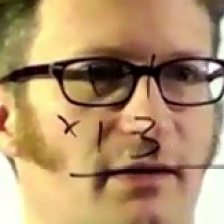

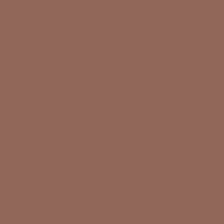

In [50]:
from google.colab.patches import cv2_imshow
cv2_imshow(y_val[0])
cv2_imshow(decoder_y_pred[0])

In [0]:
model_decoder.save(PATH_TO_MAIN + 'Models/Decoder1_81.h5')